In [1]:
%load_ext autoreload
%autoreload 2
import os

In [2]:
# %load compute_homology.py
import networkx as nx
import torch
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import pickle
import persim  # see persim.scikit-tda.org
from ripser import ripser  # see ripser.scikit-tda.org

from archs.mnist.fc1 import fc1 as fc1_mnist
from archs.cifar10.fc1 import fc1 as fc1_cifar10

from archs.mnist.AlexNet import AlexNet as AlexNet_mnist
from archs.mnist.AlexNet import AlexNet_nmp as AlexNet_nmp_mnist
from archs.cifar10.AlexNet import AlexNet as AlexNet_cifar10
from archs.cifar10.AlexNet import AlexNet_nmp as AlexNet_nmp_cifar10

from archs.mnist.LeNet5 import LeNet5 as LeNet5_mnist
from archs.mnist.LeNet5 import LeNet5_nmp as LeNet5_nmp_mnist
from archs.cifar10.LeNet5 import LeNet5 as LeNet5_cifar10
from archs.cifar10.LeNet5 import LeNet5_nmp as LeNet5_nmp_cifar10

from archs.mnist.resnet import resnet18 as resnet18_mnist
from archs.mnist.resnet_nmp import resnet18 as resnet18_nmp_mnist
from archs.cifar10.resnet import resnet18 as resnet18_cifar10
from archs.cifar10.resnet_nmp import resnet18 as resnet18_nmp_cifar10

from nn_homology import nn_graph
import argparse

import matplotlib.pyplot as plt

model_graph_dict = {}

def get_model_param_info(model_name, dataset):
    model_param = {
        "fc1_mnist": fc1_mnist,
        "fc1_cifar10": fc1_cifar10,

        "alexnet_mnist": AlexNet_mnist,
        "alexnet_nmp_mnist": AlexNet_nmp_mnist,
        "alexnet_cifar10": AlexNet_cifar10,
        "alexnet_nmp_cifar10": AlexNet_nmp_cifar10,

        "lenet5_mnist": AlexNet_mnist,
        "lenet5_nmp_mnist": LeNet5_nmp_mnist,
        "lenet5_cifar10": LeNet5_cifar10,
        "lenet5_nmp_cifar10": LeNet5_nmp_cifar10,

        "resnet18_mnist": resnet18_mnist,
        "resnet18_nmp_mnist": resnet18_nmp_mnist,
        "resnet18_cifar10": resnet18_cifar10,
        "resnet18_nmp_cifar10": resnet18_nmp_cifar10
    }
    architecture = model_name + "_" + dataset
    print("Getting parameters for: ", architecture)
    param_info = model_param[architecture]().param_info
    return param_info


def compute_homology(model, dataset, root_dir):
    for listed_file in sorted(os.listdir(root_dir)):
        if (listed_file[0].isdigit()):
            print("epoch: ", listed_file)
            if listed_file != ".ipynb_checkpoints":
                best_model_per_pruning_it_location = root_dir + listed_file + "/" + "model_lt_20.pth.tar"
                # print(best_model_per_pruning_it_location)
                if (os.path.isfile(best_model_per_pruning_it_location)):
                    computer_per_model_homology(model, dataset, root_dir, listed_file,
                                                best_model_per_pruning_it_location)

                


def computer_per_model_homology(model_name, dataset, root_dir, epoch, model_location):
    rips_pickle_dir = root_dir + "pickle/"
    # print(rips_pickle_dir)
    persim_image_dir = root_dir + "persim/"
    # print(persim_image_dir)

    model = torch.load(model_location)
    if dataset == 'mnist':
        input_dim = (1, 1, 28, 28)
    elif dataset == 'cifar10':
        input_dim = (1, 3, 32, 32)

    param_info = get_model_param_info(model_name, dataset)

    architecture = model_name + "_" + dataset
    if (architecture not in model_graph_dict) or (epoch == 0):
        print(("Architecture: {} not found, creating").format(architecture))
        NNG = nn_graph.NNGraph()
        NNG.parameter_graph(model, param_info, input_dim, ignore_zeros=True)
        #model_graph_dict[architecture] = NNG
    else:
        print(("Architecture: {} found, loading ... ").format(architecture))
        # NNG = model_graph_dict[architecture]
        NNG.update_adjacency(model)

    rips = ripser(nx.to_scipy_sparse_matrix(NNG.G), distance_matrix=True, maxdim=2, do_cocycles=True)
    # root_dir contains something in the format of:
    # /home/udit/programs/LTHT/remote_data/saves/alexnet_nmp/mnist/0/

    if not (os.path.isdir(rips_pickle_dir)):
        os.mkdir(rips_pickle_dir)
    rips_file = rips_pickle_dir + epoch
    rips_pickle = open(rips_file + ".pickle", "wb")
    pickle.dump(rips, rips_pickle)
    rips_pickle.close()

    # save ripser file as pickle
    persim.plot_diagrams(rips['dgms'])

    if not (os.path.isdir(persim_image_dir)):
        os.mkdir(persim_image_dir)
    persim_plot_file = persim_image_dir + epoch
    plt.savefig(persim_plot_file + ".jpg")
    plt.clf()


def main(args):
    ROOT_DIR = args.root_dir
    model_name = args.model_name
    dataset = args.dataset
    seed = args.seed

    model_dataset_seed_dir = ROOT_DIR + "{}/{}/{}/".format(model_name, dataset, seed)
    print("In: ", model_dataset_seed_dir)

    if (os.path.isdir(model_dataset_seed_dir)):
        compute_homology(model_name, dataset, model_dataset_seed_dir)


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()

#     parser.add_argument("--root_dir", default="/home/udit/programs/LTHT/data/saves/", type=str)
#     parser.add_argument("--model_name", default='fc1', type=str)
#     parser.add_argument("--dataset", default='mnist', type=str)
#     parser.add_argument("--seed", default='0', type=str)

#     args = parser.parse_args()
#     print(args)
#     main(args)


In [3]:
os.getcwd()

'/home/udit/programs/LTHT/LTHT'

In [4]:
ROOT_DIR = '/home/udit/programs/LTHT/data/saves/' # need absolute root dir location
# ROOT_DIR = '/home/udit/programs/LTHT/remote_data/saves/' # need absolute root dir location
# model_list = ['alexnet_nmp', 'fc1', 'lenet5_nmp', 'resnet18', 'resnet18_nmp', 'vgg16']
model_list = ['fc1'] #, 'fc1', 'lenet5_nmp', 'alexnet_nmp']
dataset_list = ['mnist', 'cifar10']
random_seed = ['0', '42', '1337']
# model_graph_dict = {}

In [5]:
for model_name in model_list:
    print(model_name)
    for dataset in dataset_list:
        print(dataset)
        for seed in random_seed:
            print(seed)
            model_dataset_seed_dir = ROOT_DIR + "{}/{}/{}/".format(model_name, dataset, seed)
            if (os.path.isdir(model_dataset_seed_dir)):
                compute_homology(model_name, dataset, model_dataset_seed_dir)
        break
    break

fc1
mnist
0
epoch:  0


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1
Layer: Linear2
Layer: Linear3
epoch:  1
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  2
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  3
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  4
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  5
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  6
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  7
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  8
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  9
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
42
epoch:  0
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  1
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  2
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  3
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  4
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  5
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  6
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  7
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  8
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  9
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
1337
epoch:  0
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  1
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  2
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  3
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  4
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  5
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  6
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  7
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  8
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3
epoch:  9
Getting parameters for:  fc1_mnist
Architecture: fc1_mnist not found, creating
Layer: Linear1


/home/udit/anaconda3/envs/ltht/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'archs.mnist.fc1.fc1' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Layer: Linear2
Layer: Linear3


<Figure size 432x288 with 0 Axes>

In [12]:
import dionysus as dion
seeds = [0,42,1337]
rips_dirs = list(map(lambda x: "/home/udit/programs/LTHT/data/saves/fc1/mnist/{}/pickle/".format(x), seeds))
all_files = []
for rips_dir in rips_dirs:
    files = sorted([rips_dir+f for f in os.listdir(rips_dir) if not f.startswith('.')])
    all_files.extend(files)
    
matrix = []
x = []
y = []
for file1 in all_files:        
    row = np.zeros(len(all_files))
    split1_name = file1.split('/')
    seed, file1_name = split1_name[-3], split1_name[-1]
    x.append(seed+"-"+file1_name.split(".")[0])

    rips1 = pickle.load(open(file1, 'rb'))
    d1 = dion.Diagram(list(rips1['dgms'][0]))

    for i, file2 in enumerate(all_files):
        rips2 = pickle.load(open(file2, 'rb'))
        d2 = dion.Diagram(list(rips2['dgms'][0]))
        # %time wdist = dion.wasserstein_distance(d1, d2, q=2)
        bdist = dion.bottleneck_distance(d1, d2)

        row[i] = bdist

    matrix.append(row)


#print(list(map(lambda x: x.split('.')[0], files)))
#print(np.asarray(matrix))

In [13]:
import seaborn as sb

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

In [14]:
x

['0-0',
 '0-1',
 '0-2',
 '0-3',
 '0-4',
 '0-5',
 '0-6',
 '0-7',
 '0-8',
 '0-9',
 '42-0',
 '42-1',
 '42-2',
 '42-3',
 '42-4',
 '42-5',
 '42-6',
 '42-7',
 '42-8',
 '42-9',
 '1337-0',
 '1337-1',
 '1337-2',
 '1337-3',
 '1337-4',
 '1337-5',
 '1337-6',
 '1337-7',
 '1337-8',
 '1337-9']

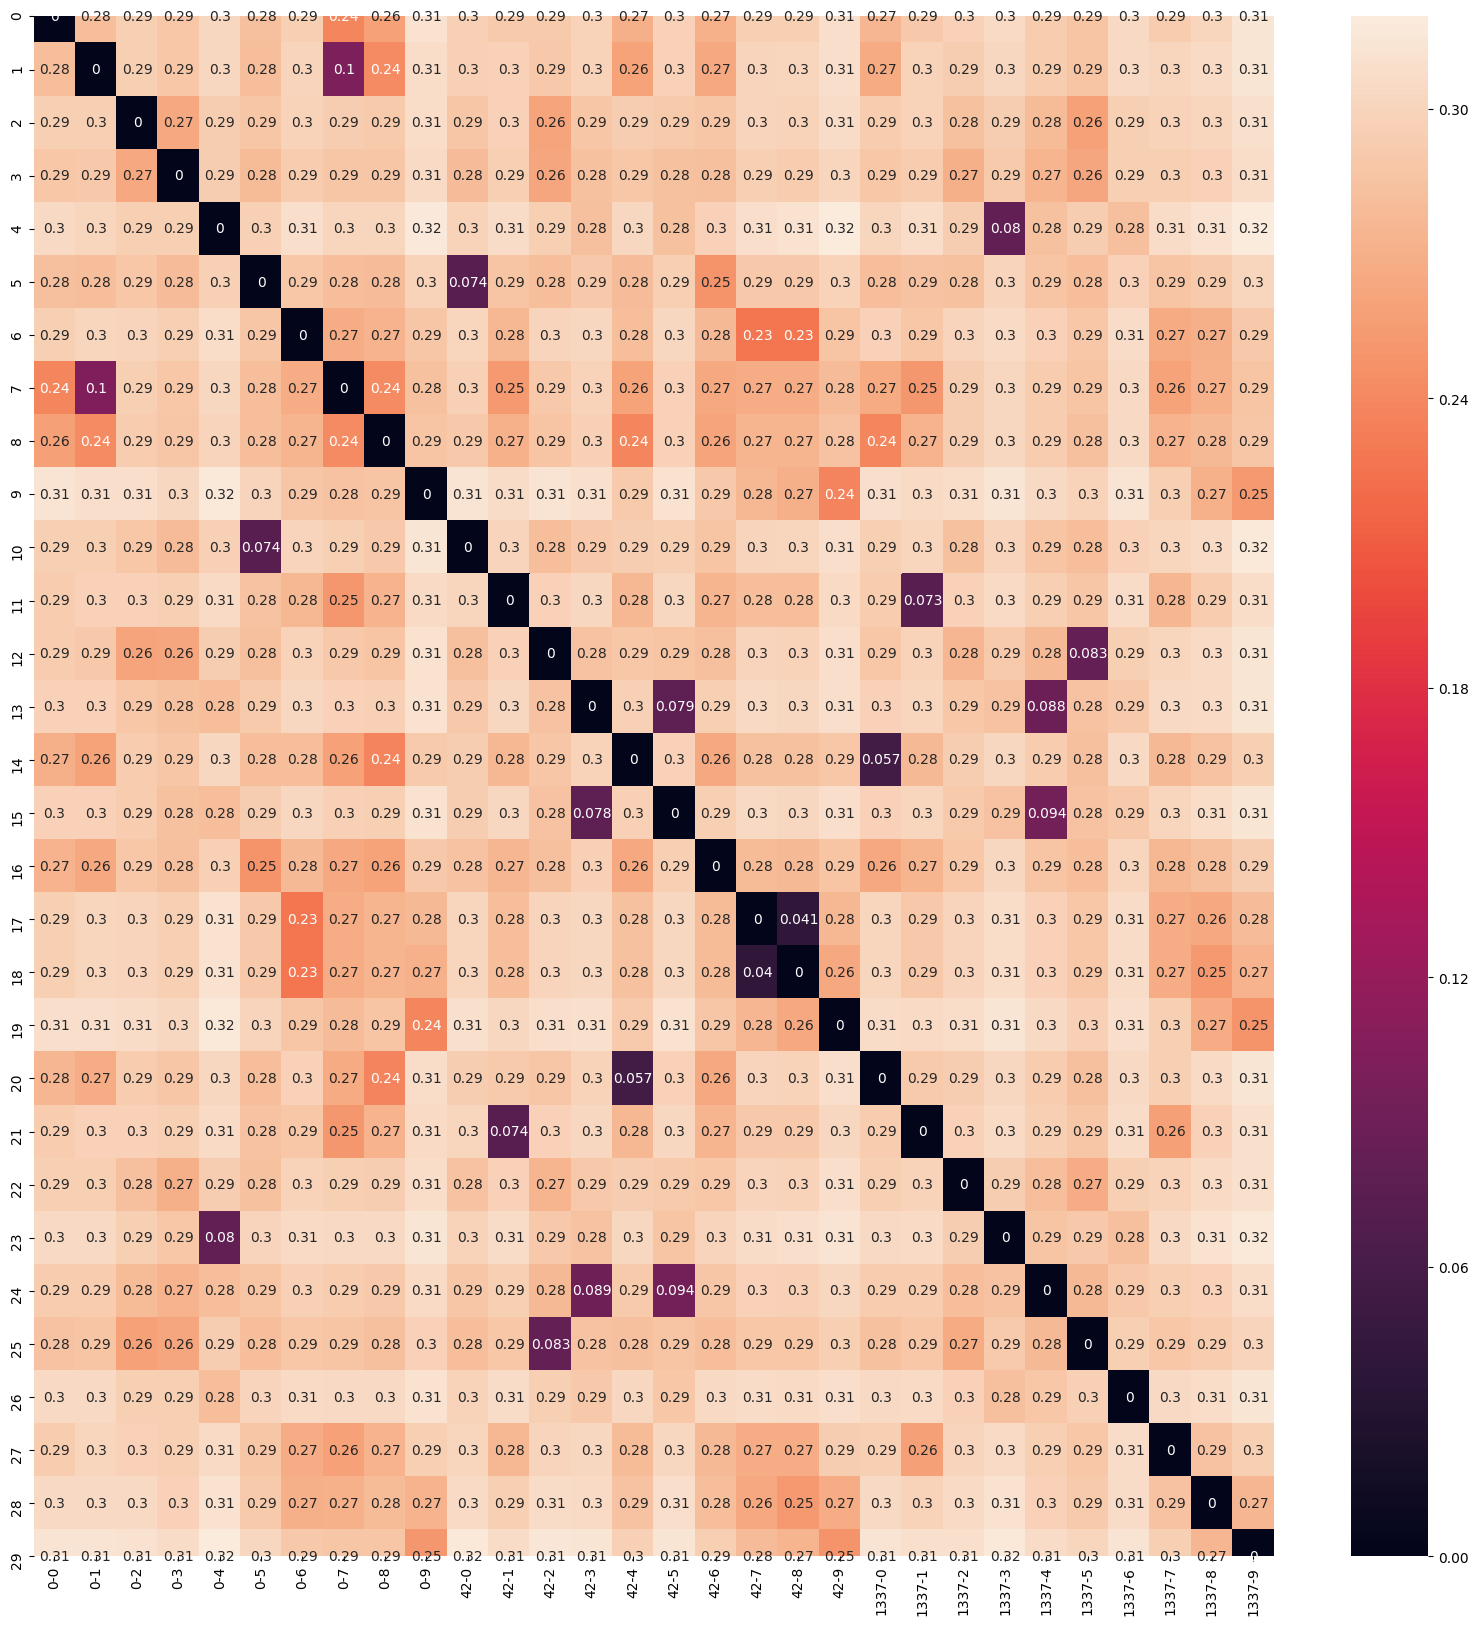

In [15]:
heat_map = sb.heatmap(np.asarray(matrix), annot=True, xticklabels=x)

In [11]:
seeds = [0,42,1337]
rips_dirs = list(map(lambda x: "/home/udit/programs/LTHT/data/saves/fc1/mnist/{}/pickle/".format(x), seeds))
all_files = []
for rips_dir in rips_dirs:
    files = sorted([rips_dir+f for f in os.listdir(rips_dir) if not f.startswith('.')])
    all_files.extend(files)
for f in all_files:
    print(f)
    split_name = f.split('/')
    print(split_name[-1], split_name[-3])

/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/0.pickle
0.pickle 0
/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/1.pickle
1.pickle 0
/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/2.pickle
2.pickle 0
/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/3.pickle
3.pickle 0
/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/4.pickle
4.pickle 0
/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/5.pickle
5.pickle 0
/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/6.pickle
6.pickle 0
/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/7.pickle
7.pickle 0
/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/8.pickle
8.pickle 0
/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/9.pickle
9.pickle 0
/home/udit/programs/LTHT/data/saves/fc1/mnist/42/pickle/0.pickle
0.pickle 42
/home/udit/programs/LTHT/data/saves/fc1/mnist/42/pickle/1.pickle
1.pickle 42
/home/udit/programs/LTHT/data/saves/fc1/mnist/42/pickle/2.pickle
2.pickle 42
/home/udit/programs

In [41]:
rips_dirs

['/home/udit/programs/LTHT/data/saves/fc1/mnist/0/pickle/',
 '/home/udit/programs/LTHT/data/saves/fc1/mnist/42/pickle/',
 '/home/udit/programs/LTHT/data/saves/fc1/mnist/1337/pickle/']